In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
reports_df = pd.read_csv('report_pages_ds.csv', index_col=0)
reports_df.head()

,report_num,page_num,text
0,341,187,период летний обычный период существенный влия...
1,1173,9,основной направление природоохранный экология ...
2,49,75,мнение заинтересованный сторона внутренний вне...
3,1253,99,действие сфера культура спор тот г. средство в...
4,942,64,л


In [24]:
e_df = pd.read_csv('esg_words.csv')
e_df.head()

,topic_name,topic_id,words
0,E,2,"эколог, экологическии, экологичныи, экологичес..."
1,Вода,11,"водоочистныи, водозаборныи, водопотребление, в..."
2,Энергия,12,"энергозатраты, энергоресурсы, энергосбытовыи, ..."
3,E,14,"эколог, природоохранныи, экологичныи, газа, га..."
4,Экологический менеджмент,15,"природоохранныи, эколог, охрана, безопасность,..."


In [25]:
def group_and_get_unique(words_lst):
    full_lst = ', '.join(words_lst)
    all_words = full_lst.split(', ')
    return ' '.join(set(all_words))

e_df = e_df.groupby('topic_name').agg({'words': group_and_get_unique})
e_df.head()

,words
topic_name,
E,биосферныи инициативность окружение газопровод...
Биоразнообразие,биосферныи дискриминация граница неограниченны...
Вода,водоснабжение осадки расход гидроразрыв пруд о...
Газ,газопровод севергазпром газоочистка согаз нефт...
Климат,граница климат углерод география агрохимически...


In [33]:
for topic_name, _ in e_df.iterrows():
    print(topic_name)

E
Биоразнообразие 
Вода
Газ
Климат
Отходы
Экологический менеджмент
Энергия


In [26]:
pages_words = reports_df['text'].tolist()
environment_words = e_df['words'].tolist()
all_words = pages_words + environment_words

In [27]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(all_words)

<118165x9136 sparse matrix of type '<class 'numpy.float64'>'
	with 14153634 stored elements in Compressed Sparse Row format>

In [28]:
def compute_cosine_similarity(text1, text2, vectorizer=vectorizer):
    # converts text into vectors with the TF-IDF 
    tfidf_text1 = vectorizer.transform([text1])
    tfidf_text2 = vectorizer.transform([text2])
    
    # computes the cosine similarity
    cs_score = cosine_similarity(tfidf_text1, tfidf_text2)
    
    return np.round(cs_score[0][0],2)

In [34]:
e_rating = defaultdict(int)
e_rating_pages = defaultdict(int)
e_rating_pages_detailed = defaultdict(int)
for report_id, report_df in tqdm(reports_df.groupby('report_num')):
    for _, page in report_df.iterrows():
        for topic_name, secondary_topic in e_df.iterrows():
            res = compute_cosine_similarity(page.text, secondary_topic.words)
            e_rating[report_id] += res
            e_rating_pages[(report_id, page.page_num)] += res
            e_rating_pages[(topic_name, 
                            report_id, page.page_num)] = res

100%|███████████████████████████████████████| 1187/1187 [27:45<00:00,  1.40s/it]


In [35]:
reports_info = pd.read_csv('rspp_reports.csv', index_col=0)
reports_info.head()

,компания,сектор,год,тип отчета,ссылка на отчет
0,РУДН,"Образование, здравоохранение",2021,ОУР,/download/7033aa33d6bfc2f5e069f547a5b15109/
1,"ОАО ""МРСК Урала""",Энергетика,2021,ИО,/download/af503e07dd6b861d1ed3048c36868cc9/
2,"ПАО ""Россети Сибирь""",Энергетика,2021,ИО,/download/57becde4be827f45bedf2a46f58d793a/
3,"ПАО ""Россети Юг""",Энергетика,2021,ИО,/download/851fbaea09387885cefa38bd3b6838f3/
4,ПАО «Россети Ленэнерго»,Энергетика,2021,ИО,/download/2034b8c8e84e4bba78049bdd976fc122/


In [36]:
# reports_info['E'] = reports_info.index.map(e_rating)
# reports_info['E'].describe(percentiles=[.25, .5, .75, .90, .99])

In [37]:
# reports_info['E'] = np.log1p(reports_info['E'])
# reports_info['E'] = reports_info['E'] / reports_info['E'].max()
# reports_info['E'].describe(percentiles=[.25, .5, .75, .85, .9, .99])

In [38]:
reports_info['E'] = reports_info.index.map(e_rating)
reports_info.sample(5)

,компания,сектор,год,тип отчета,ссылка на отчет,E
376,ПАО «Газпром нефть»,Нефтегазовая,2019,ОУР,/download/2727afe18a04c5fe922a58317df5d796/,12.90
408,ОАО «Головной институт «ВНИПИЭТ»,Энергетика,2017,ИО,/download/76daa1d1c623425a575d59546d8e2e74/,4.02
322,ПАО «ГМК «Норильский никель»,Металлургическая и горнодобывающая,2013,СО,/download/b1f6178c4ef95dca0529cfb5671ee271/,5.50
295,ВЭБ РФ,Финансы и страхование,2018,ОУР,/download/6754eb660f0b070ce31aaacccd01edec/,3.71
364,ПАО «Газпром»,Энергетика,2010,ЭО,/download/432939126c51f4849ca6f5771db7f087/,11.92


In [42]:
# reports_df['E'] = e_rating_pages[(reports_df.report_num, reports_df.page_num)]
# reports_df['E'] = reports_df.apply(lambda x: e_rating_pages[(x.report_num, x.page_num)])
reports_df['E_sum'] = list(map(lambda x: e_rating_pages[(x[0], x[1])], 
                           zip(reports_df.report_num, reports_df.page_num)))
for topic_name, _ in e_df.iterrows():
    reports_df[topic_name] = list(map(lambda x: e_rating_pages[(topic_name, x[0], x[1])], 
                                      zip(reports_df.report_num, 
                                          reports_df.page_num)))
reports_df.rename(columns={'E': 'E_global'}, inplace=True)

reports_df.sample(5)

,report_num,page_num,text,E_sum,E_global,Биоразнообразие,Вода,Газ,Климат,Отходы,Экологический менеджмент,Энергия
37495,762,54,внешний ресурс персонал повышение квалификация...,0.04,0.01,0.00,0.0,0.01,0.00,0.0,0.01,0.01
98264,417,35,эффка тивность участие специалист росатом прис...,0.02,0.00,0.00,0.0,0.00,0.00,0.0,0.01,0.01
3914,604,213,разработать процедура определять необходимый д...,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00
82250,464,298,показатель соответствие номер страница полный ...,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00
59568,887,109,приложение таблица стандарт и показатель назва...,0.05,0.01,0.01,0.0,0.00,0.01,0.0,0.01,0.01


In [45]:
reports_info.to_csv('reports_info_E.csv')
reports_df.to_csv('pages_info_E.csv')

## Новый день

In [78]:
reports_info_df = pd.read_csv('reports_info_E.csv', index_col=0)
print(reports_info_df.shape)
reports_info_df.head()

(1388, 6)


,компания,сектор,год,тип отчета,ссылка на отчет,E
0,РУДН,"Образование, здравоохранение",2021,ОУР,/download/7033aa33d6bfc2f5e069f547a5b15109/,0.00
1,"ОАО ""МРСК Урала""",Энергетика,2021,ИО,/download/af503e07dd6b861d1ed3048c36868cc9/,2.53
2,"ПАО ""Россети Сибирь""",Энергетика,2021,ИО,/download/57becde4be827f45bedf2a46f58d793a/,5.89
3,"ПАО ""Россети Юг""",Энергетика,2021,ИО,/download/851fbaea09387885cefa38bd3b6838f3/,6.88
4,ПАО «Россети Ленэнерго»,Энергетика,2021,ИО,/download/2034b8c8e84e4bba78049bdd976fc122/,7.34


In [79]:
reports_info_df[reports_info_df['E'] == 0].E.count()

227

In [68]:
reports_info_df = reports_info_df[reports_info_df['год'].apply(len) == 4]

,компания,сектор,год,тип отчета,ссылка на отчет,E
0,РУДН,"Образование, здравоохранение",2021,ОУР,/download/7033aa33d6bfc2f5e069f547a5b15109/,0.00
1,"ОАО ""МРСК Урала""",Энергетика,2021,ИО,/download/af503e07dd6b861d1ed3048c36868cc9/,2.53
2,"ПАО ""Россети Сибирь""",Энергетика,2021,ИО,/download/57becde4be827f45bedf2a46f58d793a/,5.89
3,"ПАО ""Россети Юг""",Энергетика,2021,ИО,/download/851fbaea09387885cefa38bd3b6838f3/,6.88
4,ПАО «Россети Ленэнерго»,Энергетика,2021,ИО,/download/2034b8c8e84e4bba78049bdd976fc122/,7.34


In [69]:
df_repeats = reports_info_df.groupby('компания').count()
df_repeats = df_repeats[df_repeats['год'] > 1]
df_repeats.shape

(167, 5)

In [70]:
reports_info_df.shape

(1279, 6)

In [71]:
df_repeats = df_repeats[['E']]
df_repeats.index

Index(['Alcoa, Inc.', 'BP p.l.c.', 'Deloitte CIS', 'EVRAZ PLC', 'En+ Group ',
       'Etalon Group', 'GV Gold', 'HEINEKEN в России', 'MAYKOR',
       'PwC в России',
       ...
       'ПАО «Юнипро»', 'ПАО АНК «Башнефть»', 'Петропавловск',
       'Пивоваренная компания «Балтика»', 'Почта России ', 'РОЛЬФ',
       'Рыбаков Фонд', 'Союз российских пивоваров', 'ФК «УРАЛСИБ»', 'Яндекс'],
      dtype='object', name='компания', length=167)

In [72]:
df_repeats = reports_info_df[reports_info_df['компания'].isin(df_repeats.index)]
print(df_repeats.shape)
df_repeats = df_repeats[['компания', 'год', 'E']]
df_repeats.head()

(1227, 6)


,компания,год,E
17,Etalon Group,2021,0.00
19,"ПАО ""ЯТЭК""",2021,6.93
20,"ПАО ""ЯТЭК""",2021,5.11
21,"ПАО ""ЯТЭК""",2021,5.11
22,Etalon Group,2020,0.00


In [73]:
import matplotlib.pyplot as plt

In [74]:
def e_in_different_years(company_name, df, ax):
    ax.plot(df['год'].astype(int), df['E'].astype(float))
    ax.set_xlabel('год')
    ax.set_ylabel('E')
    ax.set_title(company_name)

In [75]:
df_repeats['компания'].unique().shape

(167,)

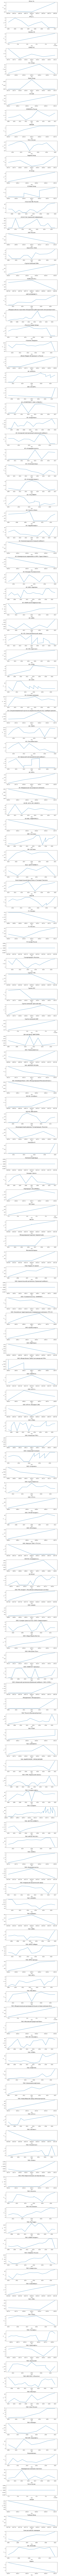

In [76]:
fig, axs = plt.subplots(167, 1, figsize=(10, 167*3))
plt.subplots_adjust(hspace=0.5)
for ax, (company_name, company_df) in zip(axs, 
                                          df_repeats.groupby('компания')):
    e_in_different_years(company_name, company_df, ax)